In [ ]:
import pandas as pd
import glob
import pyBigWig
import seaborn as sns
data='/labs/mpsnyder/moqri/data/meth/wg/mice/'
mm_='http://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/mm10.chromAlias.txt'
ez_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE94nnn/GSE94300/suppl/GSE94300_E14Ezh2_MAnorm_unbiased.bed.gz'
h_='http://smithdata.usc.edu/methbase/data/Stadler-Mouse-2011/Mouse_ESC/tracks_mm10/Mouse_ESC.meth.bw'
meta_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE80nnn/GSE80672/matrix/GSE80672_series_matrix.txt.gz'

h=pyBigWig.open(h_)
h1=h.intervals("chr"+str(1))
print(len(h1))
h1=pd.DataFrame(h1)
h1.index=h1[1]
h1=h1[2]
h1l=h1[h1<.2]
h1l.shape

mm=pd.read_table(mm_,index_col=1)
mm.columns=['','','ch']
meta=pd.read_table(meta_,skiprows=34,header=None).T
meta=meta[meta[5]=='Whole Blood']
meta=meta[meta[11]=='genetic condition: Wild Type']
meta['gsm']=meta[46].str[3:]
meta['age']=meta[9].str.strip('age (years): ').astype(float)
meta.index=meta.gsm

all_files = glob.glob(data + "*.gz")
li = []
for f in all_files:
    gsm=f.split('GSM')[1].split('_')[0]
    if gsm in meta.gsm.tolist():
        print('',end='-')
        df= pd.read_table(f, index_col=None, header=0, usecols=[1])
        df.columns=[gsm]
        li.append(df)
df = pd.concat(li, axis=1)

In [3]:
df.to_csv(data+'m.csv')

KeyboardInterrupt: 

In [ ]:
ezs=[]
ez=pd.read_table(ez_,header=None)
ez.columns=['chrom', 'chromStart', 'chromEnd']
print(ez.shape)
for ch in range(1,20):
    ezc=ez[ez['chrom']=='chr'+str(ch)]
    print(len(ezc),end=',')
    ezc['r']=ezc.apply(lambda x:range(x['chromStart'],x['chromEnd']),1)
    ezc=ezc['r'].tolist()
    ezc=set([item for sublist in ezc for item in sublist])   
    print(len(ezc),end='-')
    for b in ezc:
        ezs.append([str(ch),b])


ezs=pd.DataFrame(ezs)
ezs.columns=['ch','pos']
ezs['ez']=True
m= pd.read_table(all_files[0], index_col=None, header=0)
m.columns=['i','p','c']
m['m_ch']=m.i.str.split('|').str[3]
m['pos']=m.i.str.split('|').str[4].str.strip(':').astype(int)
ma=m.merge(mm[['ch']],left_on='m_ch',right_index=True)
me=ma.merge(ezs,left_on=['ch','pos'],right_on=['ch','pos'],how='left')
me.shape

mez=me[me.pos.isin(ezs.pos)]

<ipython-input-11-e5b44a5896f2>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dg=pd.concat([df.loc[mez.index].mean(),meta[[12,'age']].loc[df.columns]],1)


<AxesSubplot:xlabel='age', ylabel='0'>

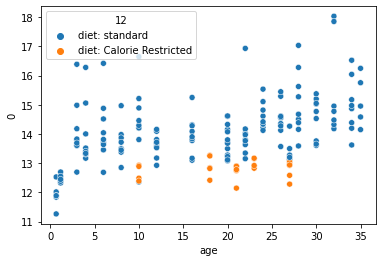

In [11]:
dg=pd.concat([df.loc[mez.index].mean(),meta[[12,'age']].loc[df.columns]],1)
sns.scatterplot(data=dg[dg[0]<20],x='age',y=0,hue=12)

<ipython-input-8-0bb99f5dd237>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dg=pd.concat([df[~df.index.isin(mez.index)].mean(),meta[[12,'age']].loc[df.columns]],1)


<AxesSubplot:xlabel='age', ylabel='0'>

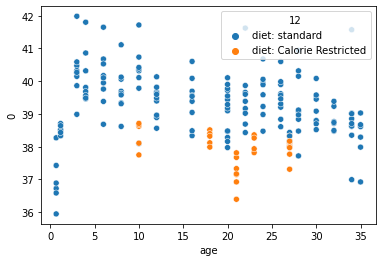

In [8]:
dg=pd.concat([df[~df.index.isin(mez.index)].mean(),meta[[12,'age']].loc[df.columns]],1)
sns.scatterplot(data=dg,x='age',y=0,hue=12)

In [18]:
df[df['2132713']>.5].mean()

2132715    50.605726
2132824    55.420606
2132721    53.294989
2132935    54.562147
2132748    53.351683
             ...    
2132856    55.396799
2132938    54.736937
2132860    54.708124
2132831    56.207655
2132840    55.021315
Length: 195, dtype: float64

<ipython-input-24-c05238709887>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dg=pd.concat([df[df['2132713']<.5].mean(),meta[[12,'age']].loc[df.columns]],1)


<AxesSubplot:xlabel='age', ylabel='0'>

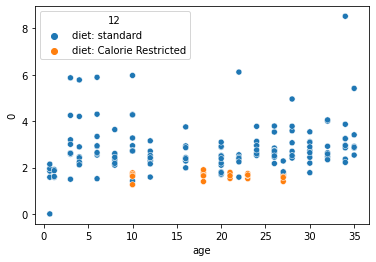

In [24]:
dg=pd.concat([df[df['2132713']<.5].mean(),meta[[12,'age']].loc[df.columns]],1)
sns.scatterplot(data=dg,x='age',y=0,hue=12)